# Custom Named Entity Recognition model using **Ktrain BioBert_NER**

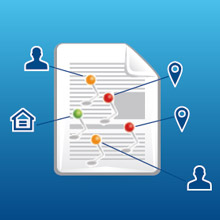

##Load and Preprocess Data

In [33]:
import pandas as pd

In [34]:
train_df= pd.read_csv('/content/train.tsv', delimiter = '\t', quoting = 3,header=None)
train_df.columns=["Word","Tag"]


In [35]:
test_df= pd.read_csv('/content/test.tsv', delimiter = '\t', quoting = 3,header=None)
test_df.columns=["Word","Tag"]

In [36]:
train_df.sample(n=5)

,Word,Tag
17471,cocaine,O
41444,SBP,O
11193,of,O
1584,6,O
71946,e,O


In [37]:
tags2vals = list(set(train_df["Tag"].values))
tag2idx = {t: i for i, t in enumerate(tags2vals)}

In [38]:
tags2vals

['O', 'I', 'B']

In [39]:
TRAIN_DATA = 'train_dev.tsv'
VALIDATION_DATA = 'test.tsv'

### intall ktrain

In [40]:
!pip install ktrain

In [41]:
import ktrain
import matplotlib.pyplot as plt
from ktrain import text

In [42]:
(trn, val, preproc) = text.entities_from_txt(train_filepath=TRAIN_DATA, val_filepath=VALIDATION_DATA, data_format='conll2003')

detected encoding: utf-8 (if wrong, set manually)
Number of sentences:  9141
Number of words in the dataset:  14023
Tags: ['O', 'I', 'B']
Number of Labels:  3
Longest sentence: 225 words


In [43]:
text.print_sequence_taggers()

bilstm: Bidirectional LSTM (https://arxiv.org/abs/1603.01360)
bilstm-bert: Bidirectional LSTM w/ BERT embeddings
bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1603.01360)
bilstm-elmo: Bidirectional LSTM w/ Elmo embeddings [English only]
bilstm-crf-elmo: Bidirectional LSTM-CRF w/ Elmo embeddings [English only]


In [ ]:
# Load model
model = text.sequence_tagger('bilstm-bert', preproc, bert_model='monologg/biobert_v1.1_pubmed')

In [45]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128, eval_batch_size=64)

In [46]:
# Train using SGDR
learner.set_model(model)

###  Train and Evaluate Model

In [47]:
learner.fit(1e-3, 3, cycle_len=1, cycle_mult=2, early_stopping=3)

preparing training data ...done.
preparing validation data ...done.
Epoch 1/7
72/72 [==============================] - 138s 2s/step - loss: 0.0622 - val_loss: 0.0418
Epoch 2/7
72/72 [==============================] - 134s 2s/step - loss: 0.0278 - val_loss: 0.0208
Epoch 3/7
72/72 [==============================] - 136s 2s/step - loss: 0.0186 - val_loss: 0.0199
Epoch 4/7
72/72 [==============================] - 136s 2s/step - loss: 0.0163 - val_loss: 0.0168
Epoch 5/7
72/72 [==============================] - 136s 2s/step - loss: 0.0123 - val_loss: 0.0165
Epoch 6/7
72/72 [==============================] - 136s 2s/step - loss: 0.0100 - val_loss: 0.0164
Epoch 7/7
72/72 [==============================] - 136s 2s/step - loss: 0.0090 - val_loss: 0.0165
Weights from best epoch have been loaded into model.


In [48]:
# Validation
learner.validate()
learner.view_top_losses(n=1)

   F1:  80.26
              precision    recall  f1-score   support

           _       0.76      0.85      0.80      4424

   micro avg       0.76      0.85      0.80      4424
   macro avg       0.76      0.85      0.80      4424
weighted avg       0.76      0.85      0.80      4424

total incorrect: 12
Word            True : (Pred)
We             :O     (O)
used           :O     (O)
high           :O     (O)
-              :O     (O)
resolution     :O     (O)
MRI            :O     (O)
and            :O     (O)
surface        :O     (O)
-              :O     (O)
based          :O     (O)
computational  :O     (O)
image          :O     (O)
analyses       :O     (O)
to             :O     (O)
map            :O     (O)
regional       :O     (O)
abnormalities  :B     (O)
in             :I     (O)
the            :I     (O)
cortex         :I     (O)
,              :I     (O)
hippocampus    :I     (O)
,              :I     (O)
white          :I     (O)
matter         :I     (O)
,            

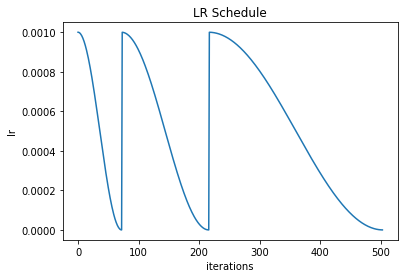

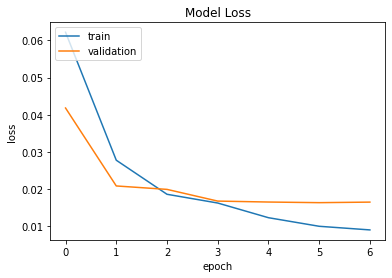

In [50]:
# Plot
learner.plot('lr')
learner.plot('loss')
plt.show(block=True)
plt.interactive(False)

### Make Predictions on New Data

In [51]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [52]:
predictor.predict('Torsade de pointes  ventricular  tachycardia  during low dose intermittent dobutamine treatment in a patient with dilated cardiomyopathy  and congestive  heart  failure ')

[('Torsade', 'B'),
 ('de', 'I'),
 ('pointes', 'I'),
 ('ventricular', 'B'),
 ('tachycardia', 'I'),
 ('during', 'O'),
 ('low', 'O'),
 ('dose', 'O'),
 ('intermittent', 'O'),
 ('dobutamine', 'O'),
 ('treatment', 'O'),
 ('in', 'O'),
 ('a', 'O'),
 ('patient', 'O'),
 ('with', 'O'),
 ('dilated', 'B'),
 ('cardiomyopathy', 'I'),
 ('and', 'O'),
 ('congestive', 'B'),
 ('heart', 'I'),
 ('failure', 'I')]

### Save the Model

In [53]:
predictor.save('/content/nerpred')

### load the model for predictions

In [54]:
reloaded_predictor = ktrain.load_predictor('/content/nerpred')

404 Client Error: Not Found for url: https://huggingface.co/monologg/biobert_v1.1_pubmed/resolve/main/tf_model.h5
/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1342: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


### new data prediction form load model

In [55]:
pred=reloaded_predictor.predict("Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal.The aims of this study were to confirm our previous findings in a separate cohort of patients and to determine the time course of the cardiovascular consequences of stopping selegiline in the expectation that this might shed light on the mechanisms by which the drug causes orthostatic hypotension")
for i in pred:
  if i[1]=="B" or i[1]=="I":
    print(i)

('postural', 'B')
('hypotension', 'B')
('Parkinson', 'B')
("'", 'I')
('s', 'I')
('disease', 'I')
('orthostatic', 'B')
('hypotension', 'I')
